# Reading image files

In [7]:
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

In [8]:
TRAINING_CSV_PATH = '../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [3]:
os.path.dirname(TRAINING_CSV_PATH)

'../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

In [9]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [10]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [11]:
# Reading only 200 images for the moment
images_list = build_images_list(images_df.head(200)['path'].values,
                                images_df.head(200).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)

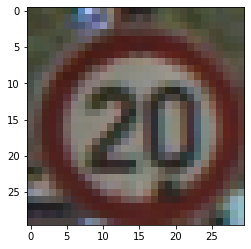

In [10]:
plt.imshow(images_list[190])

In [13]:
build_classes_array(images_df)

array([ 0,  0,  0, ..., 42, 42, 42], dtype=int64)

In [11]:
images_df['ClassId'].value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
Name: ClassId, dtype: int64

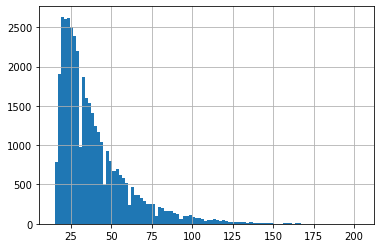

In [55]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [58]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

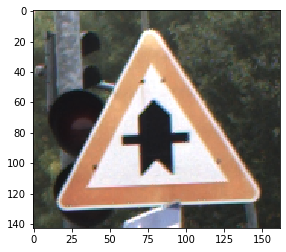

In [47]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

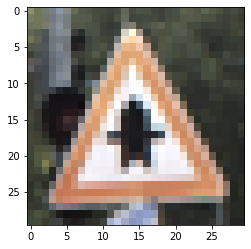

In [63]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

In [66]:
from PIL import Image

img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000/00000_00000.ppm')

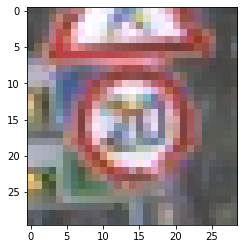

In [67]:
plt.imshow(img)

In [57]:
images_df.head(1)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


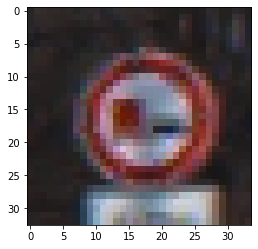

In [15]:
img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00029_00010.ppm')
plt.imshow(img)

In [8]:
img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00005_00029.ppm')

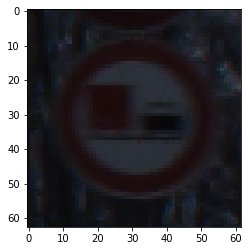

In [9]:
plt.imshow(img)

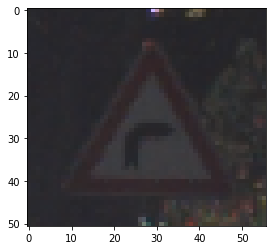

In [117]:
plt.imshow(Image.open(images_df.query('ClassId == 20').iloc[20]['path']))

## Training the model

In [23]:
np.__version__

'1.18.1'

In [15]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

#### Take a sample to test the code

In [27]:
images_df.shape

(39209, 9)

In [28]:
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [21]:
N = 10_000
images_list = build_images_list(images_df.head(N)['path'].values,
                                images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
data = np.array(images_list)
labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(10000, 30, 30, 3) (10000,)


In [24]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 30, 30, 3) (2000, 30, 30, 3) (8000,) (2000,)


In [25]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
data.memory

10000

In [26]:
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
#model.save("my_model.h5")

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 25s 3ms/step - loss: 2.1253 - accuracy: 0.5052 - val_loss: 0.3741 - val_accuracy: 0.9070
Epoch 2/15
8000/8000 [==============================] - 27s 3ms/step - loss: 0.5021 - accuracy: 0.8465 - val_loss: 0.3203 - val_accuracy: 0.8920
Epoch 3/15
8000/8000 [==============================] - 21s 3ms/step - loss: 0.3315 - accuracy: 0.9006 - val_loss: 0.1848 - val_accuracy: 0.9590
Epoch 4/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.2334 - accuracy: 0.9294 - val_loss: 0.0837 - val_accuracy: 0.9760
Epoch 5/15
8000/8000 [==============================] - 22s 3ms/step - loss: 0.1909 - accuracy: 0.9423 - val_loss: 0.0583 - val_accuracy: 0.9860
Epoch 6/15
8000/8000 [==============================] - 21s 3ms/step - loss: 0.1867 - accuracy: 0.9436 - val_loss: 0.0709 - val_accuracy: 0.9820
Epoch 7/15
8000/8000 [==============================] - 21s 3ms/step - loss: 0.139

In [34]:
test_model = load_model('../models/traffic_signs_2021-03-19_13-51-00.h5')

TypeError: __init__() got an unexpected keyword argument 'ragged'

In [35]:
from tensorflow import keras as kr

In [36]:
test_model = kr.models.load_model('../models/traffic_signs_2021-03-19_13-51-00.h5')

ValueError: ('Unrecognized keyword arguments:', dict_keys(['ragged']))

In [3]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [5]:
test_model = tf.keras.models.load_model('../models/traffic_signs_2021-03-19_13-51-00.h5')

In [6]:
test_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)         

In [12]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict_classes(np.array(images_list))

In [13]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               test_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([20], dtype=int64)

In [14]:
image_sample

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
26722,00003_00022.ppm,67,64,6,6,61,59,20,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [15]:
test = "data:application/octet-stream;base64,UDYKMjkgMzAKMjU1CktOUEpMTlZXVGxeVZJ0cqFucsF5ebGFgvLh4//6//Lu/+bq/5WhxHOKroOlsLrJu+vn6Pzy/+ra59yrtMBtcIpDQY5SVn9ibVlbYUtPUERLS0FFREJDQlNUVlBQUlpZVIhrX76Fe5lZUZxVWs+nuv/6//36//n9/7u/8H6CtpeZ0bCwrcfJit7jy/Du/PXs//TO8MqHjpVSP5JOUYJbdWdca1RRVklNTkxOS1BQTk5OUFZVVl1aW6R4esBrZpJENuCZn//v///8//f7/+fz/a+zv6uoxPnn/9q5xZWMebzKzeTq/+3r///x/92puqJia65iaJRiZXJaW15TU0hKSElKRU5OSkpLTVtTU25cZLJ1hrhRULFbR/+9w//e//////n0/+vp4761nd7O0vjf///w/+nQ6MGx0OXN9P/q///i9f/a9tiQtaJGT5VMOaZvY31gWktIQklKQ0lPSkdKR2BRSIRiYMFzd8NJSNBya/Kwtf/v//nr9vfo7uDQzc+4q+DCw+3M2+G9ydivudKjsM6YqcuOmrF5gL+Llq5ebbdKSJc2IqhSSJ1ublVMSklLSFBdXEVKQnhmVKyCdbNhWLtBQMZZX++Pk9OBg7d0da1qa6NgYJxYVpVQTpJMSo5IRYhEQIJBPYM/O4Y+Onk9OW09OHg+N4M/MZdTPZBMRIlma1NQUkpKSmlrbmVtcIJtbLmGgJlCNrxBPb1ARMBBRb9DR75FSr9IT75ITrlITrhLTrpPT75VV7lbX7djbL5rebBdYLJya59ybJdzb41yapdxZn1LSHdfY0hKSkxJRmhfX4yQnp6Onq6KirF7bLVtZ7JydLB3e7R9hLqEjsmJltiOnOSQn/GTm/GQkvGNlO6WouyftdWNrb98hphsYWxWUGNRT1pNTF9LSmVKS1RHS0VFREpIQlBMSq6uvbqvv7OdrcGsvYRvg3x4kGVxg19reGJvgn10jZN0gKt0dK9gYKNMTKxNUKJPVKtka7Z5gpxpcYBnb2BgYFlZUFdXUlhWVFJOTklGSElHR0hHREpKSLa4yLu0xMCw0ZaQwm9xoVxmlEpcfGZfcnlYdIhdgohTXohKO4lBOYtIR41PTodJSIJDPItGOJVKUIpUb5l3fHdoWFhaUFJTT0xMSktLS0pKSkdHRk1NSrC0tLKvqaWbpqKqxlp0mkVej0Zfi3tgh6FSaJNGS7FlaaVfY9STmfbHzuLFze3Dy8uUoLJldbdTWpVBQKBcX4docFdcXkxQTUxPTU1PTklLSUdHREtKRo+Ab5eNcGplWpCco1p3lExekl1jmoFXkqdMXKdZPrh3dt6uxv/l+f/v///6//Tr/dzc/Nqz4dmLk7NhQ5dCQ31QcWVfblRTUU9TUVNVUkxMSE5NR1pXUsWjfnxrTVdXSn+Pklt8lVRejHhskZthfrRMVrtsZMWOicuxr6uupdjVxOrg1a3DvYC3yXp5pLZ9ktGBgbRNUYxQWnlobF1XV1xhYFlbWVBPTFZTT1tWUdrHjoF3V0pKOnqKimCBlWRljpN1iZBQT65NUtSdqKmclJqJbYx3ULefbeLHn7KsjoOSl4Z9popoi9qdurFZYYpHOqBxa3ZhYmtwcF5hX1FSUFNTUVxbVrSvgIaDYVZVR3aGi22PqHNsmaV0iYZAPsJna+3O2aPAxrqys8GUhaN2V51wXo5rZsKpt+DO73pviOS6y8V8gYo/OaNVVI9rbWJoaFldXFJVVFJUVGBiYJaXcoOCXmRhVHd/iYmeu4d1pq10ioFAPMqBhfnb59jk+dDR8Mi+x5WGecu2uYJugtPA1uTW7392hdWzudugo4NAQaNXWZBtcV1hYlhbWlVYWFNVVlpcXHyEc4CBcXZwbX1+h3yEkJt+jrp4fn1APMyUmf/o9uTf9MnT8ICZsIiWqMHE03ZxfrWowenf/353h8etqcaYln1BQaRaW5JvclhbW1daVlVYVFRXU1teWmxydGhqbmRjaWZmbmhqZqiHd8J9c41EQL1wdv/S4u7d85qXs2x1m5uj1MvS7n+FjJabt6qv4HJ4idG1ps+RiYM/PqheX45qbVZWVFlaU1ZZUVpdVF5hWIiMlYqOmYqOmY+PmouIiLaQhbVsZ55ISLtYW/29w6mMj2xbW4N9iZ2gua25xIial3WNlmuAlouer9u9yrprbIo+NJxSToxmZ1tZV1paVVpdV11gWV5hWq+zxK2xw6uwwKSruZ6nqpGHgKSGhaNjZ6NBQbx0cdaomaqPdH53aouLjJigmrjCtbjEvNLNye3W6MCNtpVFT49TP6F5b3JdXF9cWltbWFdZVVpbVl1dWLG1wq2yvquxu6SxupSpqW5/dmt4cal/ebpZT5ZGOMmJdPDMsOPa1Ovp+eXq7+nr5ufn7//k+eKhsKhfZ7Rja5NocGxmallUVV5aW2FgYlVXV1VVUlhVUb+0vayutZmprpiqrperp2yCdlNrXYFuXq9xXaFbQpNFKsqGaPe9vvbR8fbl9v/n6v/p/+e0479/iqJjS5tdY3lYfFlUaFRSVl5eY1dYX1NVWE9RUFNVUpZ8WX19ZGJ8Z0lgT4+jlmqFe0ptXk9TP4FmT7R5X7hcS6RAN75SVK1kcsCZnqRraNOHj+ijt8OEkJ1oa4hdaGtTZVRPWVBQU1peYk5RV0xPUkhNTklRT/XPf5qPVT9PH2R1T4mbhGyHf0twYEpfRnN3XY1/ZKiHgJVgbJdOUopNSX1NRoBRR4RWTphvaa2JlZBzkoBqemNWV09LTFJSVFtfY01PVVNUWEpOUU5VVOWzb8SugFheOkRPNIeXiG2JhU52ZUZsTk5yVVl4XWJ8bIeBfJFqZLeHf6JoYZ96dI9/epCEgYqBi4N+lWxreltZYE5LUE9PUlRYWkxOT09PT01QUE5UUp2ETIJ5V2duVVddTY+UjIKUlFx8amWCXmN9XWh+Ym6AZ4KDbZWGdZmFeZ6EfY+AfYF9e42HhpmSmXx3h2xqeVxbaU1MVUpKT1BSUlFSTlJSTlJTT1FUUImIb3x/cWtzaGprZIqFg5egooScloSYiYOUh4SRhoONgICJen2GeX2EeYaMjHqAimlwcm5uaHVvcXVwe29rdmppdVJTW0ZGSkpKSk9PS01OSk5OSVtbV4WGi3p/hHB5fHN1dnZydW9vdGhtcmRrcWBpbmJobWNnZmVrY0tUS2RsYY2Umn2EnFtjaW5tYY+Fg5GJkHNtdWdjbV1aYEpIS0tJSVVUUF5eWWFiW2NnY1tfY1tiZ0pVWURIS01KTFRMTV5RVV1XXlpbYF9fYlhWWEpNTklSUUxVUYaPmX+IoVhhaXBtZpmKh62ionVtcGhhaF1WW1BLT0xISF1aV2dlX25xaGBoYlVUV19laz1KT0FHTEVERVNPTWNbXlpXYFJTWFpaXGNiaFFSXUxQVk5UVoKKmIGKpFRfamZraJCQi52dlm5ubWJeY2VeY1dSV0lHSFFQTWZmX2NmWlphWQ=="

In [16]:
test_type, test_content = test.split(',')

In [17]:
test_type

'data:application/octet-stream;base64'

In [21]:
import io
import base64

Image.open(io.BytesIO(base64.b64decode(test_content)))